In [27]:
import torch
import torch.nn as nn
import torchvision.models as models

class SimCLR(nn.Module):
    def __init__(self, base_model, out_dim=128):
        super(SimCLR, self).__init__()
        self.encoder = base_model  # 使用ResNet-18，不加载预训练权重
        fc_in_features = self.encoder.fc.in_features
        self.encoder.fc = nn.Identity()  # 移除原来的全连接层，因为我们将添加一个新的投影头

        self.proj_head = nn.Sequential(
            nn.Linear(fc_in_features, 256),  # ResNet-18的fc层的输入特征数
            nn.ReLU(),
            nn.Linear(256, out_dim)
        )

    def forward(self, x):
        h = self.encoder(x)  
        z = self.proj_head(h)  
        return h, z


In [28]:
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torchvision
class TwoCropTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, x):
        return self.transform(x), self.transform(x)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(size=224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

train_dataset_ssl = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=TwoCropTransform(train_transform))
test_dataset_ssl = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=TwoCropTransform(test_transform))
train_dataset_cifar = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
test_dataset_cifar = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [29]:
def contrastive_loss(z_i, z_j, temperature=0.5, epsilon=1e-8):
    batch_size = z_i.size(0)
    z = torch.cat([z_i, z_j], dim=0)
    
    sim_matrix = torch.exp(torch.mm(z, z.t().contiguous()) / temperature)
    
    mask = torch.cat([torch.arange(batch_size) + batch_size, torch.arange(batch_size)], dim=0).to(sim_matrix.device)

    sim_matrix_sum = sim_matrix.sum(1, keepdim=True)
    sim_matrix_sum[sim_matrix_sum == 0] = epsilon  
    sim_matrix = sim_matrix / (sim_matrix_sum - sim_matrix[range(2 * batch_size), mask].view(-1, 1))
 
    neg = sim_matrix.sum(1) - sim_matrix[range(2 * batch_size), mask]
    pos = sim_matrix[range(batch_size), batch_size + torch.arange(batch_size).to(sim_matrix.device)]
    pos = torch.cat([pos, sim_matrix[range(batch_size, 2 * batch_size), torch.arange(batch_size).to(sim_matrix.device)]], dim=0)
    
    loss = -torch.log(pos / (neg + epsilon)).mean()
    return loss

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimCLR(base_model=models.resnet18(pretrained=False), out_dim=128).to(device)
def train(model,batch_size,lr,train_dataset,val_dataset,epoch=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_dataloader=DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    test_dataloader=DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    losses = []
    train_acces = []
    val_losses = []
    best_acc = 0
    best_epoch = 0
    best_val_loss = float('inf')
    model.train()

    for i in range(epoch):
        model.train()  
        total_loss = 0
        total_train = 0
        running_correct = 0
        for batch in train_dataloader:
            x, labels = batch
            x_i,x_j=x
            x_i, x_j = x_i.to(device), x_j.to(device)
            optimizer.zero_grad()  
            _,output_i = model(x_i)
            _,output_j = model(x_j)            
            train_loss = contrastive_loss(output_i, output_j)  
            train_loss.backward()  
            optimizer.step()  
            
            total_loss += train_loss.item() * x_i.size(0)
            total_train += x_i.size(0)

        avg_train_loss = total_loss / total_train
        losses.append(avg_train_loss)

        model.eval()
        with torch.no_grad():
            val_loss = 0
            correct = 0
            total = 0
            for x,labels in test_dataloader:
                x_i,x_j=x
                x_i, x_j, labels = x_i.to(device), x_j.to(device), labels.to(device)
                _,output_i = model(x_i)
                _,output_j = model(x_j)
                loss = contrastive_loss(output_i, output_j)
                val_loss += loss.item() * x_i.size(0)

                total += x_i.size(0)

            avg_val_loss = val_loss / total
            val_losses.append(avg_val_loss)

        print(f"Epoch [{i+1}/{epoch}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
    return losses, losses, val_loss
            


/opt/conda/envs/gfnet/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/gfnet/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [31]:
train(model,batch_size=32,lr=0.00001,train_dataset=train_dataset_ssl,val_dataset=test_dataset_ssl,epoch=400)
torch.save(model.state_dict(),'ssl_weights.pth')

Epoch [1/400], Train Loss: 1.6917, Val Loss: 0.4552
Epoch [2/400], Train Loss: 1.2684, Val Loss: 0.4009
Epoch [3/400], Train Loss: 1.1793, Val Loss: 0.3589
Epoch [4/400], Train Loss: 1.1320, Val Loss: 0.3506
Epoch [5/400], Train Loss: 1.0917, Val Loss: 0.3115
Epoch [6/400], Train Loss: 1.0479, Val Loss: 0.2754
Epoch [7/400], Train Loss: 1.0280, Val Loss: 0.2732
Epoch [8/400], Train Loss: 1.0175, Val Loss: 0.2793
Epoch [9/400], Train Loss: 0.9932, Val Loss: 0.2614
Epoch [10/400], Train Loss: 0.9928, Val Loss: 0.2770
Epoch [11/400], Train Loss: 0.9727, Val Loss: 0.2605
Epoch [12/400], Train Loss: 0.9620, Val Loss: 0.2517
Epoch [13/400], Train Loss: 0.9517, Val Loss: 0.2494
Epoch [14/400], Train Loss: 0.9426, Val Loss: 0.2496
Epoch [15/400], Train Loss: 0.9302, Val Loss: 0.2436
Epoch [16/400], Train Loss: 0.9248, Val Loss: 0.2307
Epoch [17/400], Train Loss: 0.9218, Val Loss: 0.2349
Epoch [18/400], Train Loss: 0.9119, Val Loss: 0.2300
Epoch [19/400], Train Loss: 0.9048, Val Loss: 0.2359
Ep

In [32]:
import copy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimCLR(base_model=models.resnet18(pretrained=False), out_dim=128)
original_in_features = model.proj_head[0].in_features  
model.proj_head = nn.Linear(original_in_features, 100)
model.to(device)


SimCLR(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [33]:
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import copy
criterion = nn.CrossEntropyLoss()
def train_cifar(model,train_dataset,val_dataset,batch_size=32,lr_proj=0.0001,lr_encoder=0.000005,epoch=200):
    optimizer = optim.Adam([
    {'params': model.proj_head.parameters(), 'lr': lr_proj},
    {'params': [param for name, param in model.named_parameters() if "proj_head" not in name], 'lr': lr_encoder}
])
    train_dataloader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=4)
    val_dataloader=DataLoader(val_dataset,batch_size=batch_size,shuffle=False,num_workers=4)
    losses=[]
    train_acces=[]
    val_acces=[]
    val_losses=[]
    best_acc=0
    best_epoch=0
    for i in range(epoch):
        model.train()
        running_loss = 0
        running_correct = 0
        total_train = 0
        for batch in train_dataloader:
            img,label=batch
            optimizer.zero_grad()
            img=img.to(device)
            label=label.to(device)
            _,output=model(img)
            train_loss=criterion(output,label)
            train_loss.backward()
            optimizer.step()
            running_loss += train_loss.item() * img.size(0)
            _, predicted = torch.max(output, 1)
            running_correct += (predicted == label).sum().item()
            total_train += label.size(0)
            train_loss = running_loss / total_train
        train_acc = running_correct / total_train
        losses.append(train_loss)
        train_acces.append(train_acc)
        model.eval()
        val_loss = 0
        correct = 0
        total_val = 0
        with torch.no_grad():
            for batch in val_dataloader:
                img, label = batch
                img = img.to(device)
                label = label.to(device)
                _,output = model(img)
                loss = criterion(output, label)
                val_loss += loss.item() * img.size(0)
                _, predicted = torch.max(output, 1)
                correct += (predicted == label).sum().item()
                total_val += label.size(0)
        val_epoch_loss = val_loss / total_val
        val_epoch_acc = correct / total_val
        val_acces.append(val_epoch_acc)
        val_losses.append(val_epoch_loss)
        print(f'Epoch [{i+1}/{epoch}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}')
        if val_epoch_acc > best_acc:
            best_acc = val_epoch_acc
            best_epoch = i
            best_model_wts = copy.deepcopy(model.state_dict())
    print(f'Best epoch: {best_epoch+1} with accuracy: {best_acc:.4f}')
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Loss over Epochs')
    plt.plot(losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
            
    plt.subplot(1, 2, 2)
    plt.title('Accuracy over Epochs')
    plt.plot(train_acces, label='Train Accuracy')
    plt.plot(val_acces, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    model.load_state_dict(best_model_wts)
    return best_acc


Epoch [1/200], Train Loss: 3.8685, Train Acc: 0.1137, Val Loss: 3.4949, Val Acc: 0.1605
Epoch [2/200], Train Loss: 3.4554, Train Acc: 0.1790, Val Loss: 3.1071, Val Acc: 0.2357
Epoch [3/200], Train Loss: 3.1661, Train Acc: 0.2310, Val Loss: 2.8929, Val Acc: 0.2760
Epoch [4/200], Train Loss: 2.9407, Train Acc: 0.2739, Val Loss: 2.8204, Val Acc: 0.2956
Epoch [5/200], Train Loss: 2.7469, Train Acc: 0.3145, Val Loss: 2.4601, Val Acc: 0.3719
Epoch [6/200], Train Loss: 2.5910, Train Acc: 0.3440, Val Loss: 2.3934, Val Acc: 0.3844
Epoch [7/200], Train Loss: 2.4584, Train Acc: 0.3725, Val Loss: 2.3468, Val Acc: 0.3978
Epoch [8/200], Train Loss: 2.3422, Train Acc: 0.3983, Val Loss: 2.0506, Val Acc: 0.4619
Epoch [9/200], Train Loss: 2.2465, Train Acc: 0.4189, Val Loss: 2.0203, Val Acc: 0.4607
Epoch [10/200], Train Loss: 2.1584, Train Acc: 0.4365, Val Loss: 1.9519, Val Acc: 0.4763
Epoch [11/200], Train Loss: 2.0914, Train Acc: 0.4530, Val Loss: 1.7812, Val Acc: 0.5164
Epoch [12/200], Train Loss: 2.

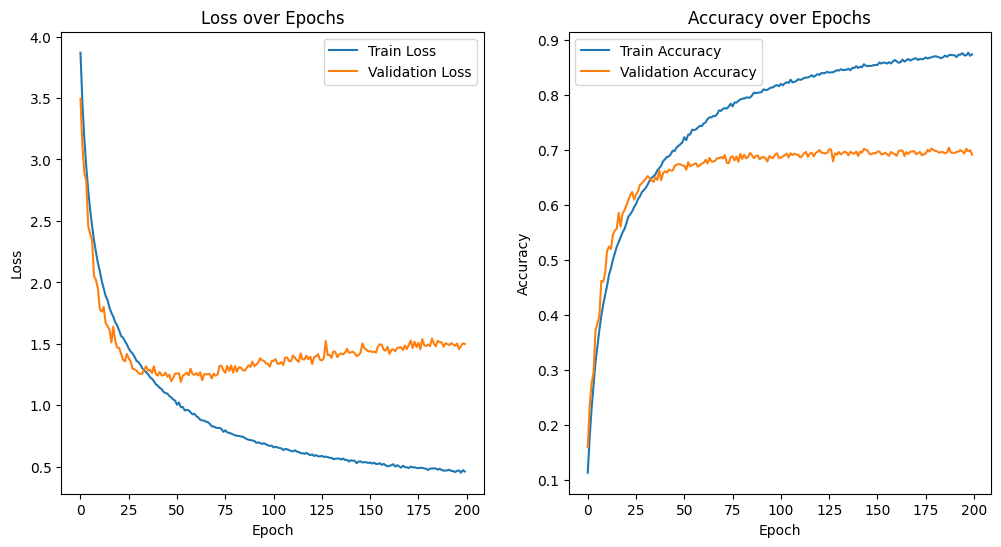

In [34]:
train_cifar(model,batch_size=64,lr_proj=0.0001,lr_encoder=0.0001,train_dataset=train_dataset_cifar,val_dataset=test_dataset_cifar,epoch=200)
torch.save(model.state_dict(),'sslpre_resnet18_weights.pth')